# 注意力分数

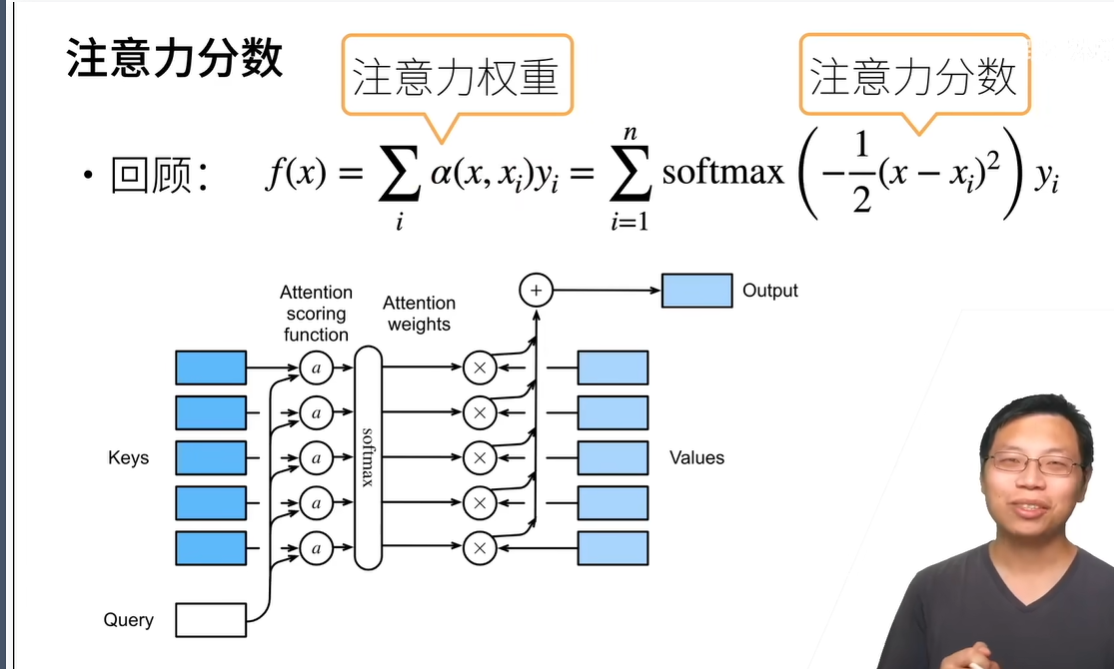

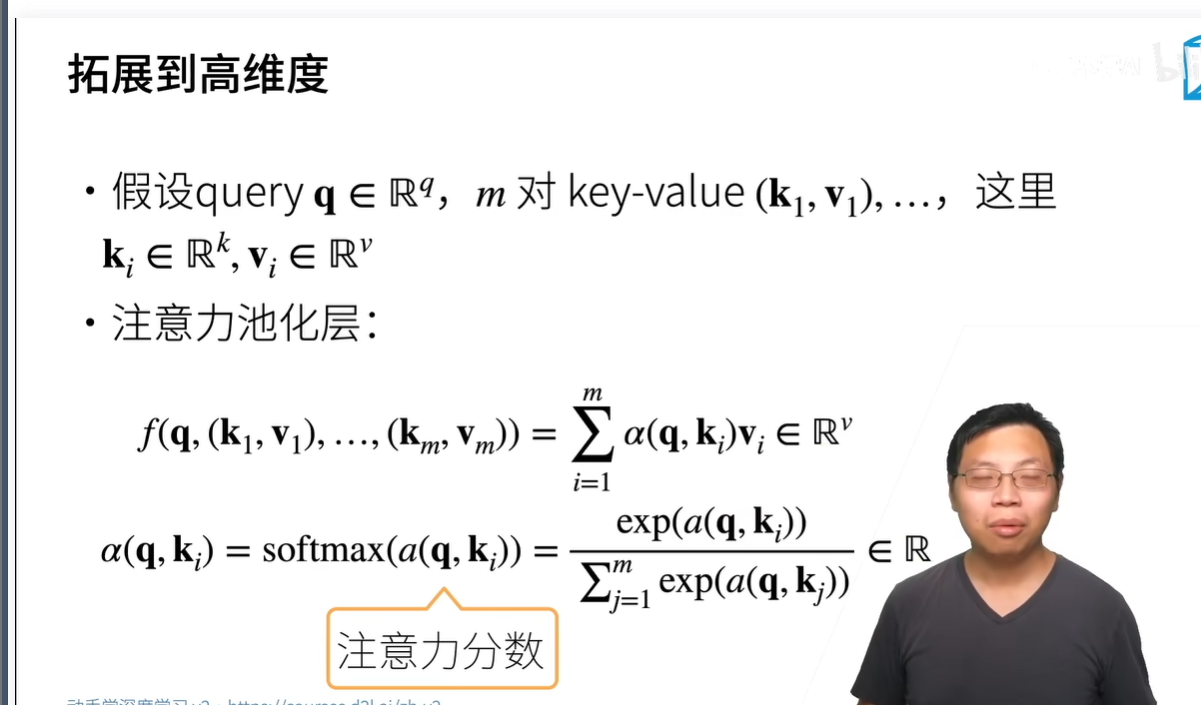

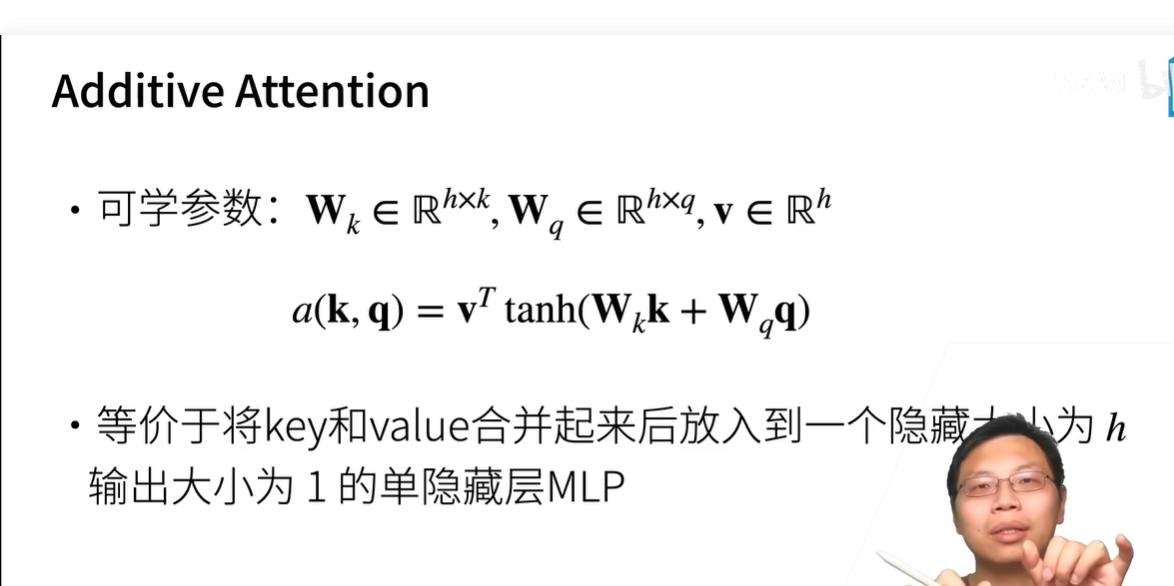

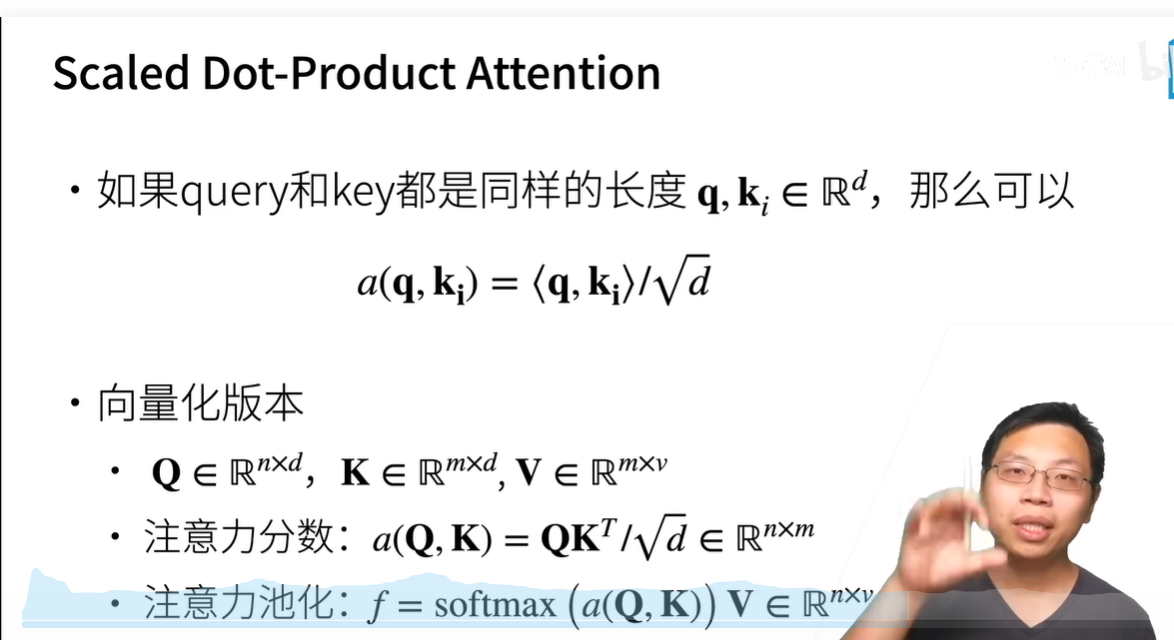

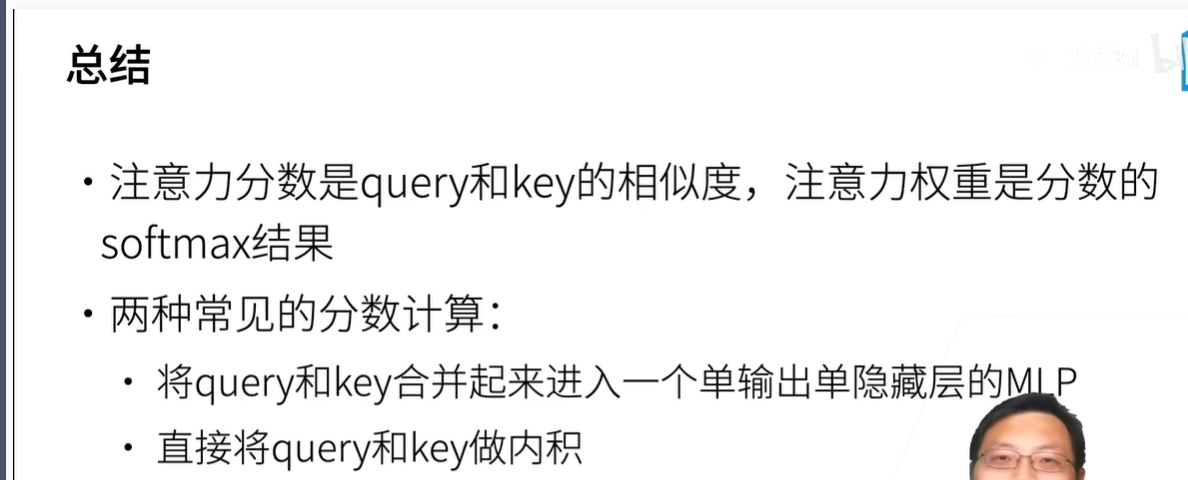

注意力机制的本质

https://www.bilibili.com/video/BV1dt4y1J7ov/?share_source=copy_web&vd_source=c675206b339487e9755eec554de241a9

# q k v分别是什么

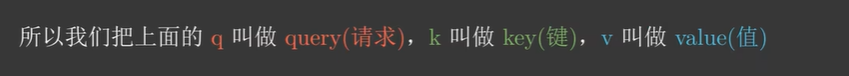

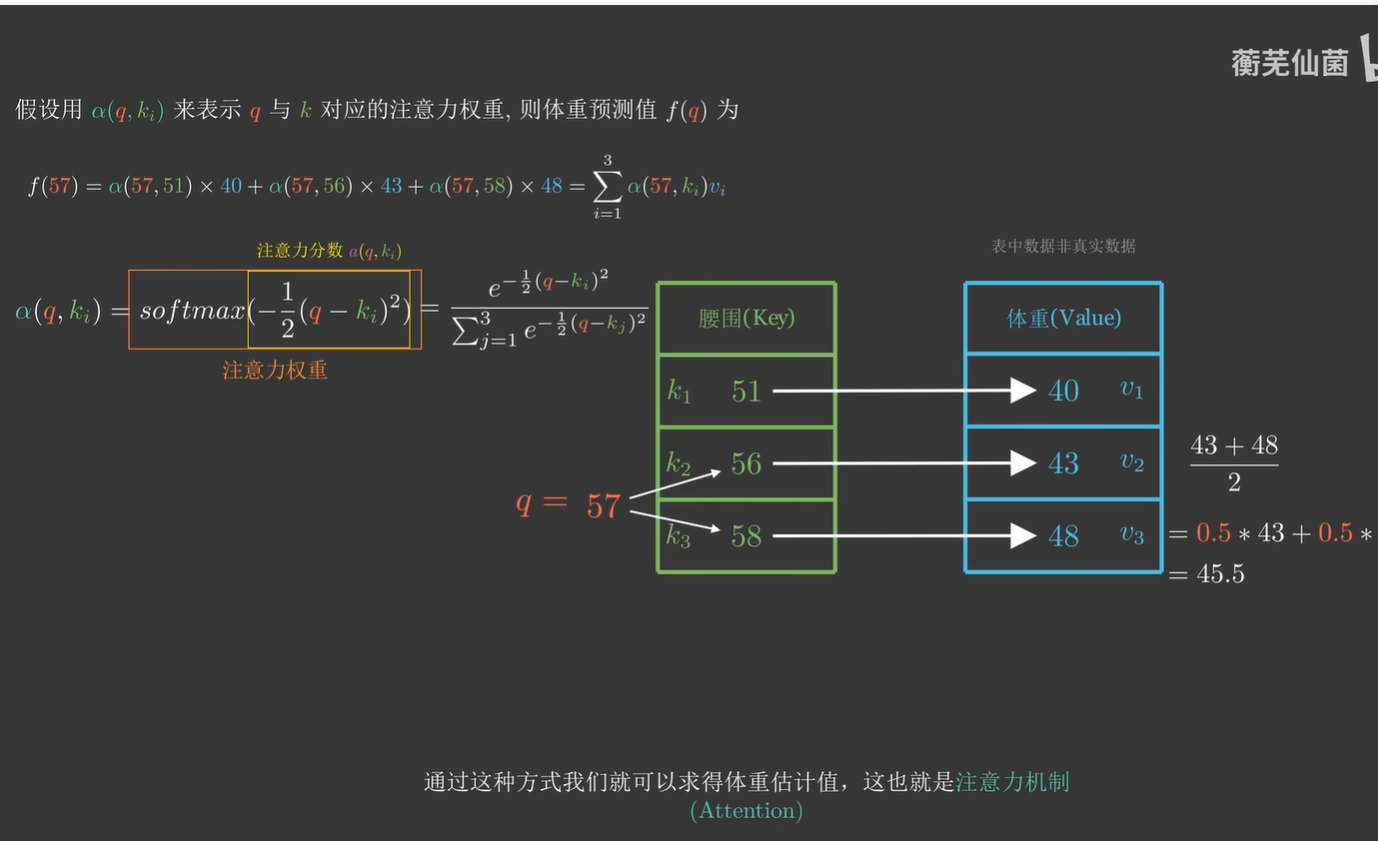

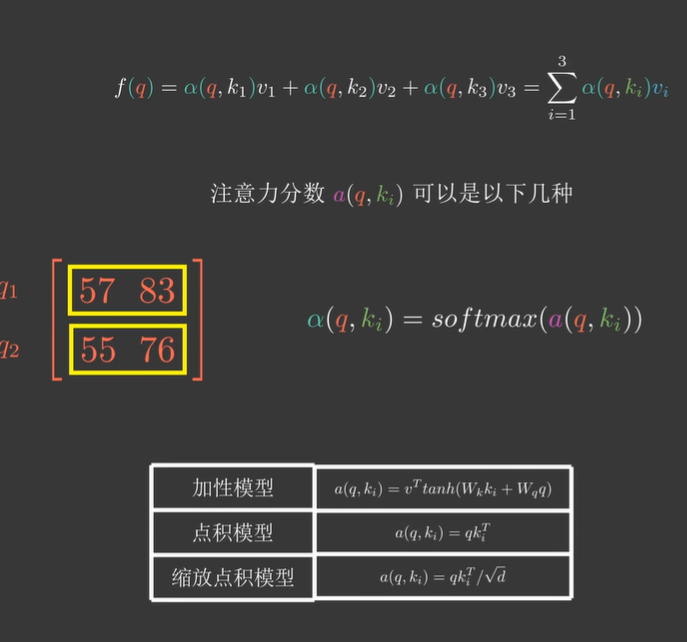

以缩放点积注意力模型为例：
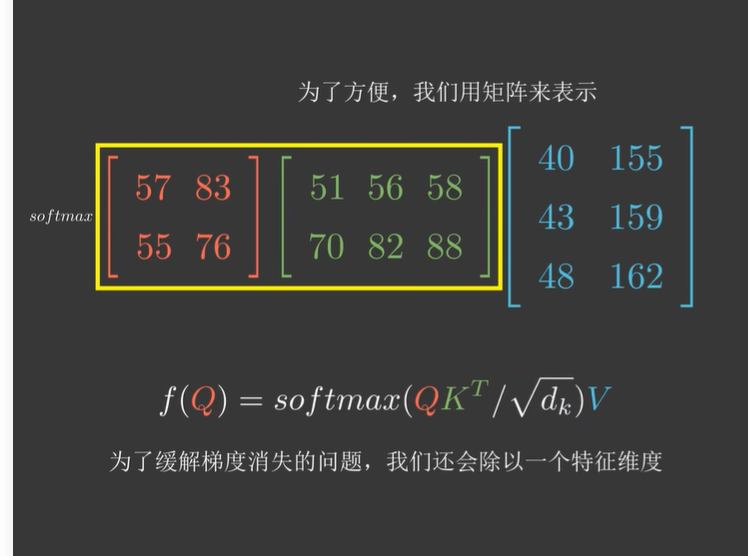

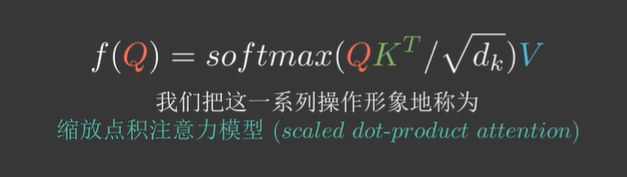

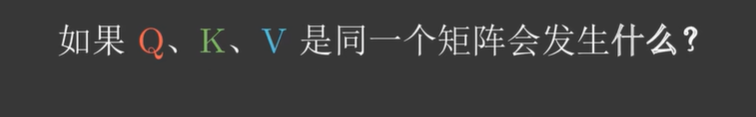

就变成了自注意力
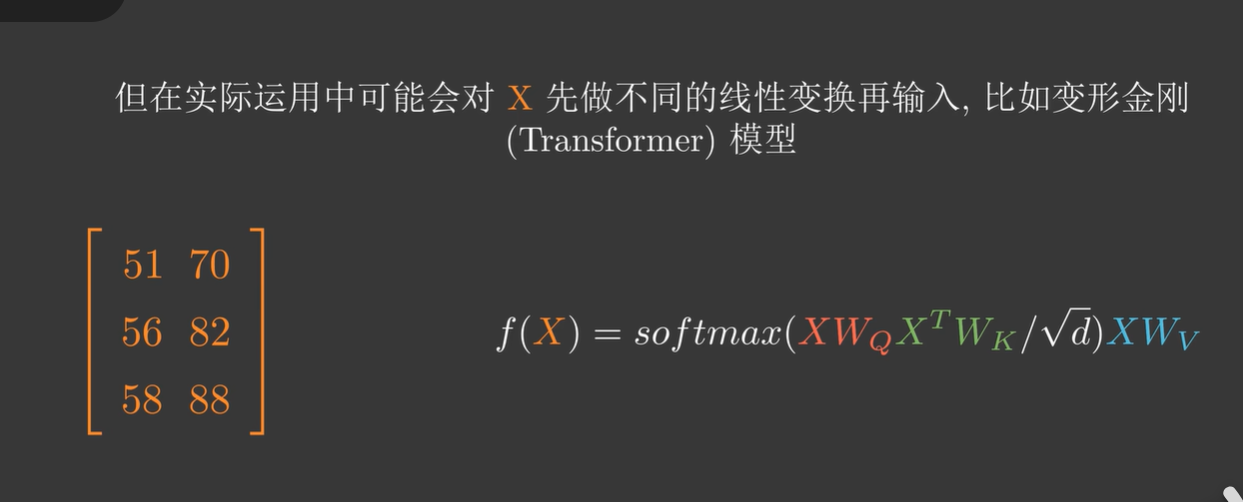

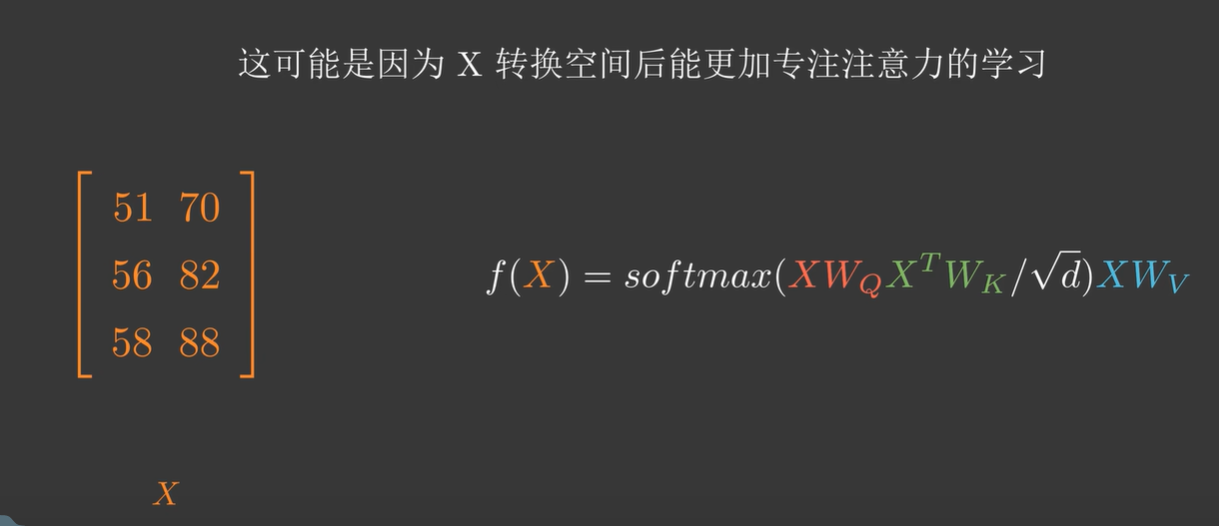

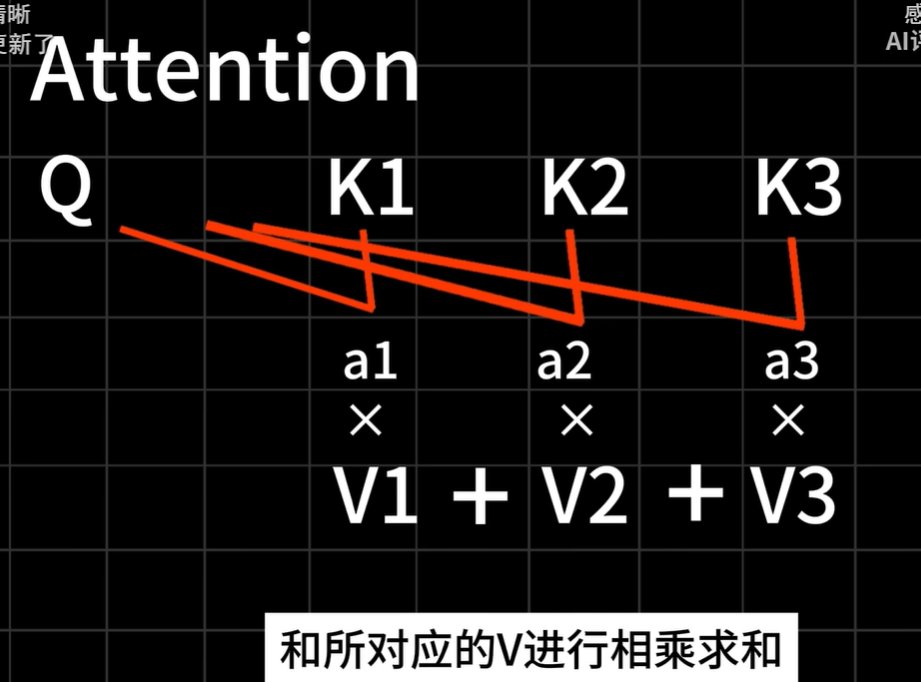

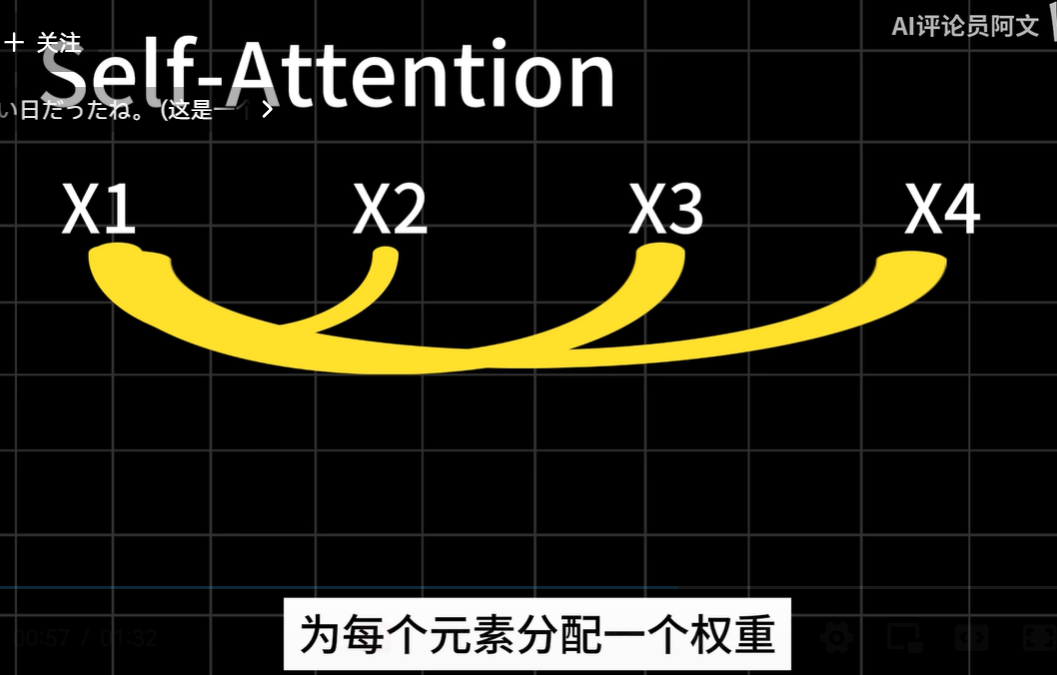

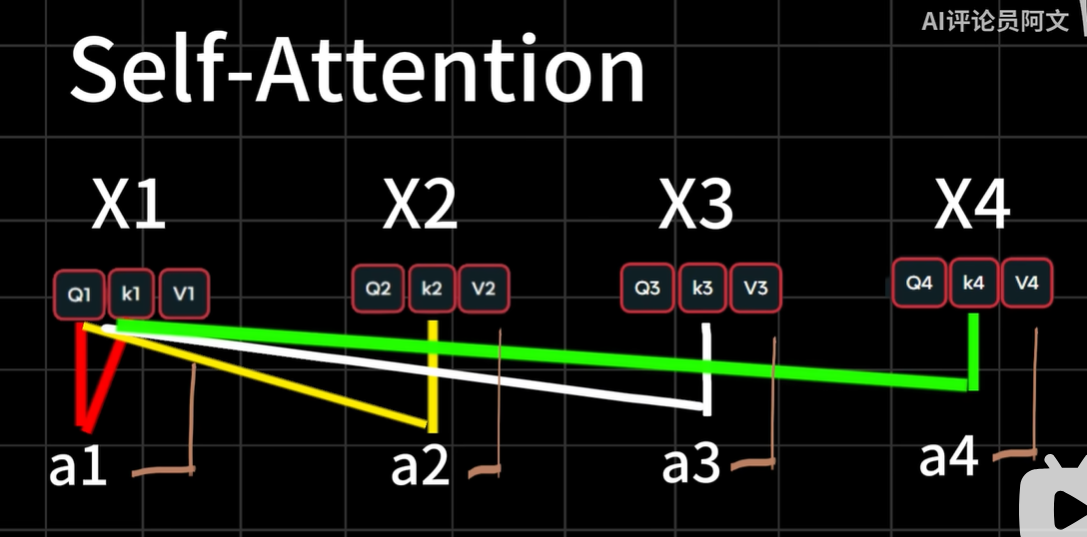

In [1]:
# 注意力打分函数
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X: 3D张量，valid_lens: 1D或2D张量
    # 如果 valid_lens 是 None，则直接对 X 在最后一个轴上应用 softmax
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        # 获取输入张量 X 的形状
        shape = X.shape
        # 如果 valid_lens 是 1D 张量，则将其扩展为与 X 匹配的形状
        if valid_lens.dim() == 1:
            # 将 valid_lens 按 shape[1] 重复，以便与 X 的形状匹配
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 如果 valid_lens 是 2D 张量，则将其展平为 1D
            valid_lens = valid_lens.reshape(-1)
        
        # 对 X 进行掩蔽，将最后一个轴上超过 valid_lens 的元素替换为一个非常大的负数 -1e6
        # 这样在 softmax 计算时，这些位置会趋近于 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        
        # 重新调整 X 的形状，最后在最后一个轴上应用 softmax
        return nn.functional.softmax(X.reshape(shape), dim=-1)


In [3]:
# 函数怎么实现的

masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5220, 0.4780, 0.0000, 0.0000],
         [0.5153, 0.4847, 0.0000, 0.0000]],

        [[0.4456, 0.2878, 0.2666, 0.0000],
         [0.2813, 0.3276, 0.3911, 0.0000]]])

In [8]:
# 同样，也可以使用二维张量
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))
#前一个有效 前三个有效
#前2个有效 前4个有效

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4361, 0.2874, 0.2765, 0.0000]],

        [[0.6253, 0.3747, 0.0000, 0.0000],
         [0.2027, 0.2153, 0.3377, 0.2444]]])

In [9]:
# 加性注意力（Additive Attention），
# 用于对查询和键之间的关系进行加性计算，最终生成注意力分数


# 加性注意力通过将查询和键通过线性变换投影到相同维度，
# 再将其相加后通过激活函数生成注意力分数，从而根据这些分数对值进行加权。
# 相比于乘性注意力（例如点积注意力），加性注意力计算量稍大，但在某些任务上表现更好。


#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # 定义用于将 keys 映射到隐层的线性变换，不使用偏置
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # 定义用于将 queries 映射到隐层的线性变换，不使用偏置
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # 定义用于将隐层输出映射为一个单一分值的线性变换
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        # 定义 dropout 层，用于防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # 使用 W_q 将 queries 投影到隐层空间
        queries, keys = self.W_q(queries), self.W_k(keys)
        
        # 维度扩展：将 queries 和 keys 在不同维度上进行广播求和
        # queries 的形状为 (batch_size, 查询的个数, 1, num_hiddens)
        # keys 的形状为 (batch_size, 1, 键值对的个数, num_hiddens)
        # 通过广播机制，计算 queries 和 keys 的加和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        
        # 使用 tanh 激活函数，将计算结果非线性变换
        features = torch.tanh(features)
        
        # self.w_v 只有一个输出维度，因此我们使用 squeeze(-1) 来去掉最后的维度
        # scores 的形状为 (batch_size, 查询的个数, 键值对的个数)
        scores = self.w_v(features).squeeze(-1)
        
        # 使用 masked_softmax 函数对 scores 进行 softmax 操作，确保被掩蔽的位置不会影响结果
        self.attention_weights = masked_softmax(scores, valid_lens)
        
        # 使用注意力权重（经过 dropout）与 values 进行加权求和，得到最终的输出
        # values 的形状为 (batch_size, 键值对的个数, 值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [10]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

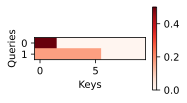

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [12]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        # 初始化函数，继承 nn.Module 类
        super(DotProductAttention, self).__init__(**kwargs)
        # 定义 Dropout 层，用于防止过拟合
        self.dropout = nn.Dropout(dropout)

    # queries 的形状：(batch_size, 查询的个数, d)
    # keys 的形状：(batch_size, “键－值”对的个数, d)
    # values 的形状：(batch_size, “键－值”对的个数, 值的维度)
    # valid_lens 的形状：(batch_size,) 或者 (batch_size, 查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        # 取 queries 的最后一个维度，即 d 表示查询向量和键向量的维度
        d = queries.shape[-1]
        # 计算查询与键的点积，并除以 sqrt(d) 进行缩放
        # bmm 是批量矩阵乘法，queries 与 keys 的转置进行矩阵相乘
        # keys.transpose(1, 2) 交换 keys 的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # 调用 masked_softmax，使用掩蔽机制处理无效长度
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 使用注意力权重对 values 进行加权求和
        return torch.bmm(self.dropout(self.attention_weights), values)


In [13]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

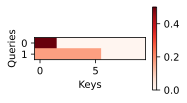

In [14]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

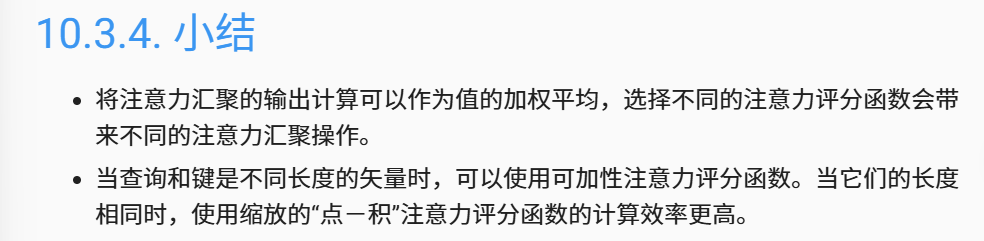